# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [9]:
# Install the required libraries
!pip install prophet


In [10]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [11]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

C:\Users\patri\AppData\Local\Temp\ipykernel_41732\1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


Search Trends
Date                              
2016-06-01 00:00:00             97
2016-06-01 01:00:00             92
2016-06-01 02:00:00             76
2016-06-01 03:00:00             60
2016-06-01 04:00:00             38

Search Trends
Date                              
2020-09-07 20:00:00             71
2020-09-07 21:00:00             83
2020-09-07 22:00:00             96
2020-09-07 23:00:00             97
2020-09-08 00:00:00             96

In [12]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


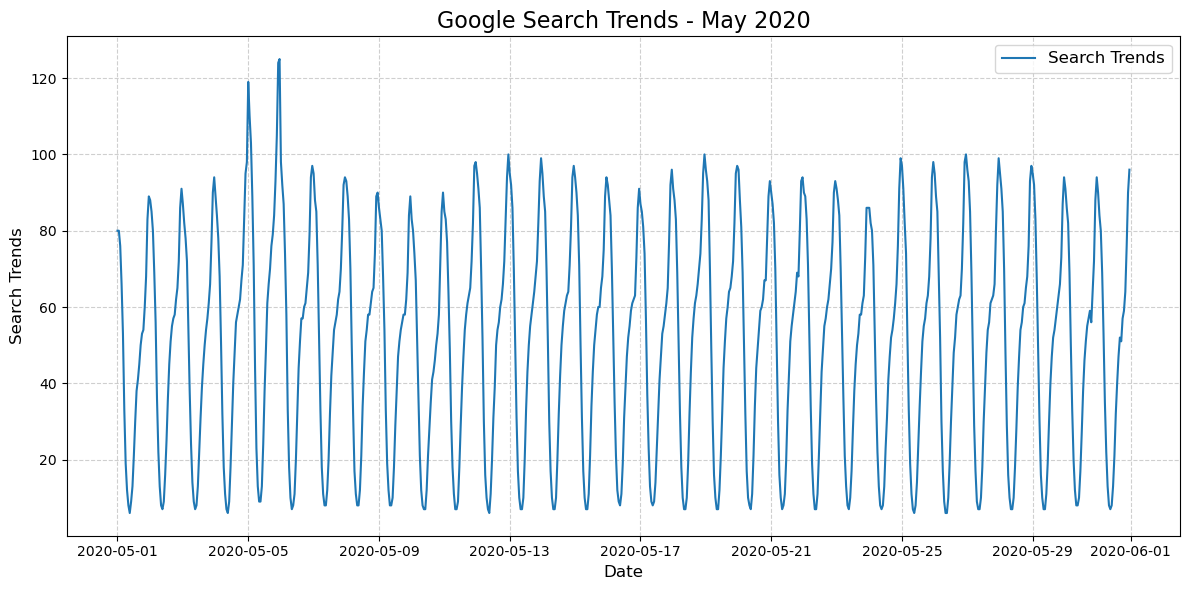

In [14]:
# Slice the DataFrame to just the month of May 2020
may_2020_data = df_mercado_trends.loc['2020-05-01':'2020-05-31']


# Plot to visualize the data for May 2020
plt.figure(figsize=(12, 6))
plt.plot(may_2020_data.index, may_2020_data['Search Trends'], label='Search Trends', linewidth=1.5)
plt.title('Google Search Trends - May 2020', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [21]:
# Calculate the sum of the total search traffic for May 2020

total_search_traffic_may_2020 = may_2020_data['Search Trends'].sum()


# View the traffic_may_2020 value
total_search_traffic_may_2020

38181

In [22]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_median_search_traffic = (
    df_mercado_trends['Search Trends']
    .resample('M')
    .sum()
    .median()
)


# View the median_monthly_traffic value
monthly_median_search_traffic

C:\Users\patri\AppData\Local\Temp\ipykernel_41732\2292107802.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


35172.5

In [27]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
comparison = total_search_traffic_may_2020 - monthly_median_search_traffic

comparison_percentage = (comparison / monthly_median_search_traffic) * 100
total_search_traffic_may_2020, monthly_median_search_traffic, comparison, comparison_percentage
total_search_traffic_may_2020/monthly_median_search_traffic

comparison = total_search_traffic_may_2020 - monthly_median_search_traffic

comparison_percentage = (comparison / monthly_median_search_traffic) * 100

total_search_traffic_may_2020, monthly_median_search_traffic, comparison, comparison_percentage


(38181, 35172.5, 3008.5, 8.553557466770915)

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**Total Search Traffic for May 2020: 38,181
            Overall Monthly Median Search Traffic: 35,172.5
            Difference (Comparison): 3,008.5
            Percentage Difference: 8.55%, So, Yes.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

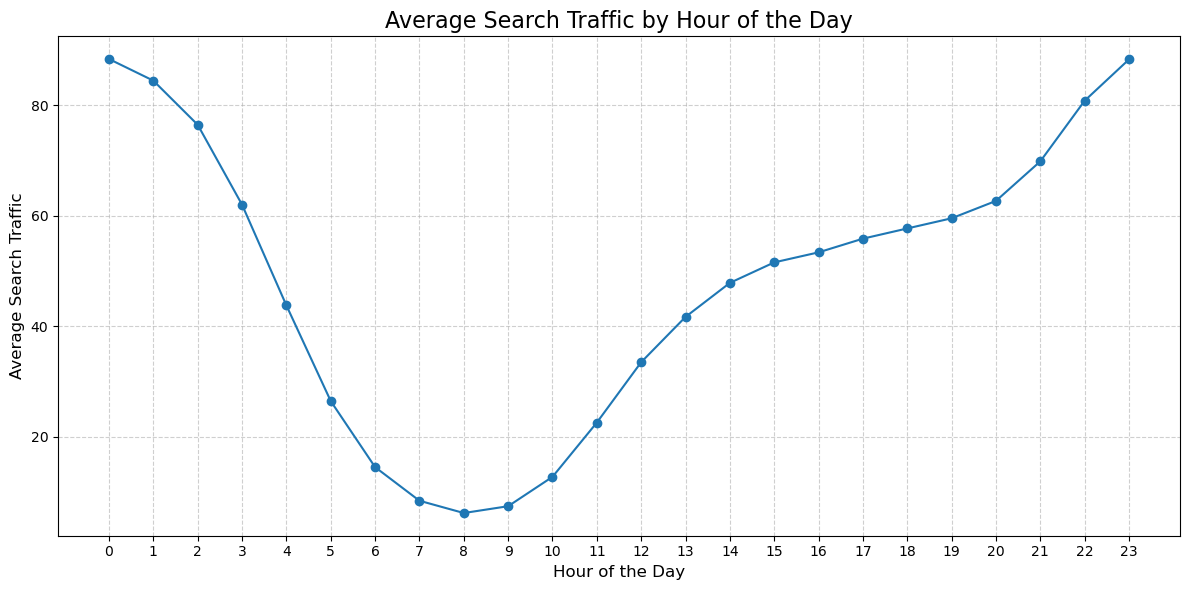

In [28]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
average_traffic_by_hour = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()
plt.figure(figsize=(12, 6))
plt.plot(average_traffic_by_hour.index, average_traffic_by_hour, marker='o', linewidth=1.5)
plt.title('Average Search Traffic by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(0, 24))  # Ensure all hours of the day are visible
plt.tight_layout()
plt.show()


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

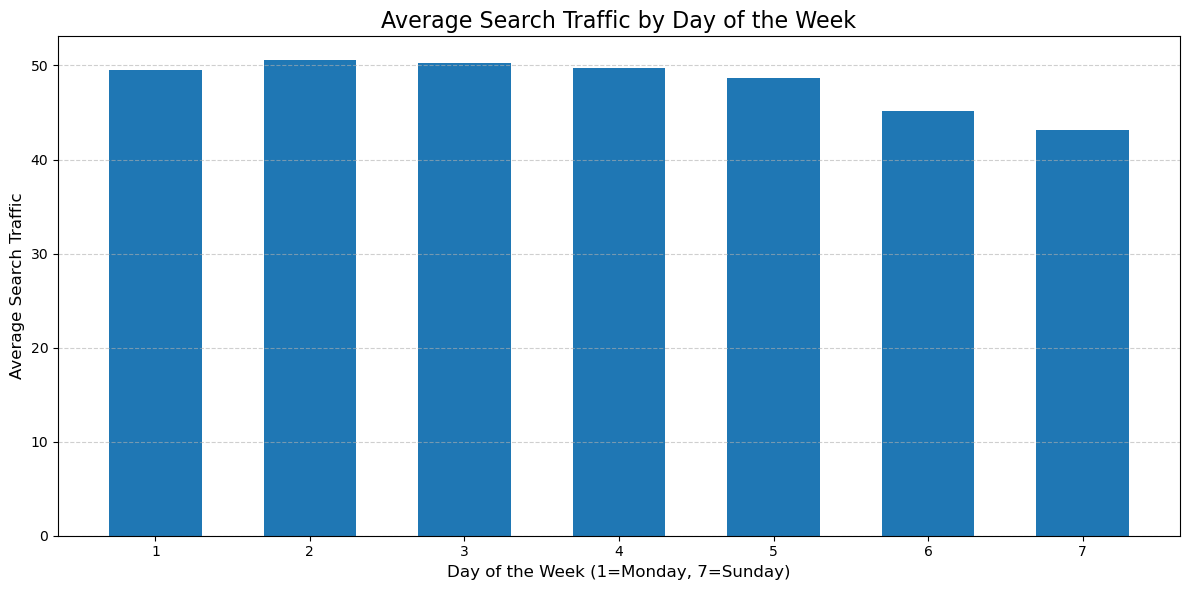

In [30]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
average_traffic_by_day_of_week = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()


plt.figure(figsize=(12, 6))
plt.bar(average_traffic_by_day_of_week.index, average_traffic_by_day_of_week, width=0.6)
plt.title('Average Search Traffic by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week (1=Monday, 7=Sunday)', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

<Axes: xlabel='week'>

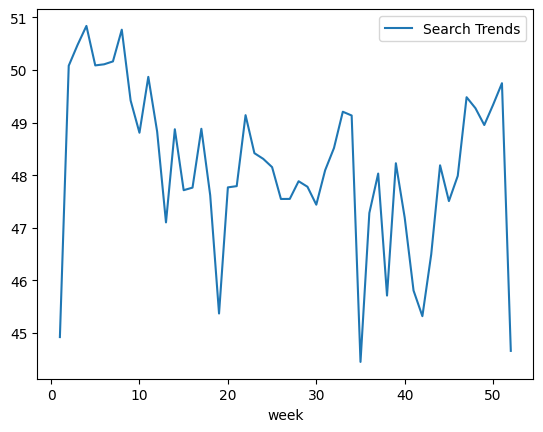

In [ ]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
average_traffic_by_week_of_year = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()

plt.figure(figsize=(12, 6))
plt.plot(average_traffic_by_week_of_year.index, average_traffic_by_week_of_year, marker='o', linewidth=1.5)
plt.title('Average Search Traffic by Week of the Year', fontsize=16)
plt.xlabel('Week of the Year', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** Yes, based on the visualizations and analysis of the data, a few time-based trends are evident:
            Traffic appears to have a daily pattern. Seems to peak during the hours of which users are most active - morning and evening hours. Much      lower when people are sleeping.
            Day trends show that Day 2 -Tuesdays are the busiest. Remainder of the days: 1,3,4 are relatively the same and lower usage emerge during day 5,6 and lowest for day 7.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [32]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

close
date                       
2015-01-02 09:00:00  127.67
2015-01-02 10:00:00  125.44
2015-01-02 11:00:00  125.57
2015-01-02 12:00:00  125.40
2015-01-02 13:00:00  125.17

close
date                         
2020-07-31 11:00:00  1105.780
2020-07-31 12:00:00  1087.925
2020-07-31 13:00:00  1095.800
2020-07-31 14:00:00  1110.650
2020-07-31 15:00:00  1122.510

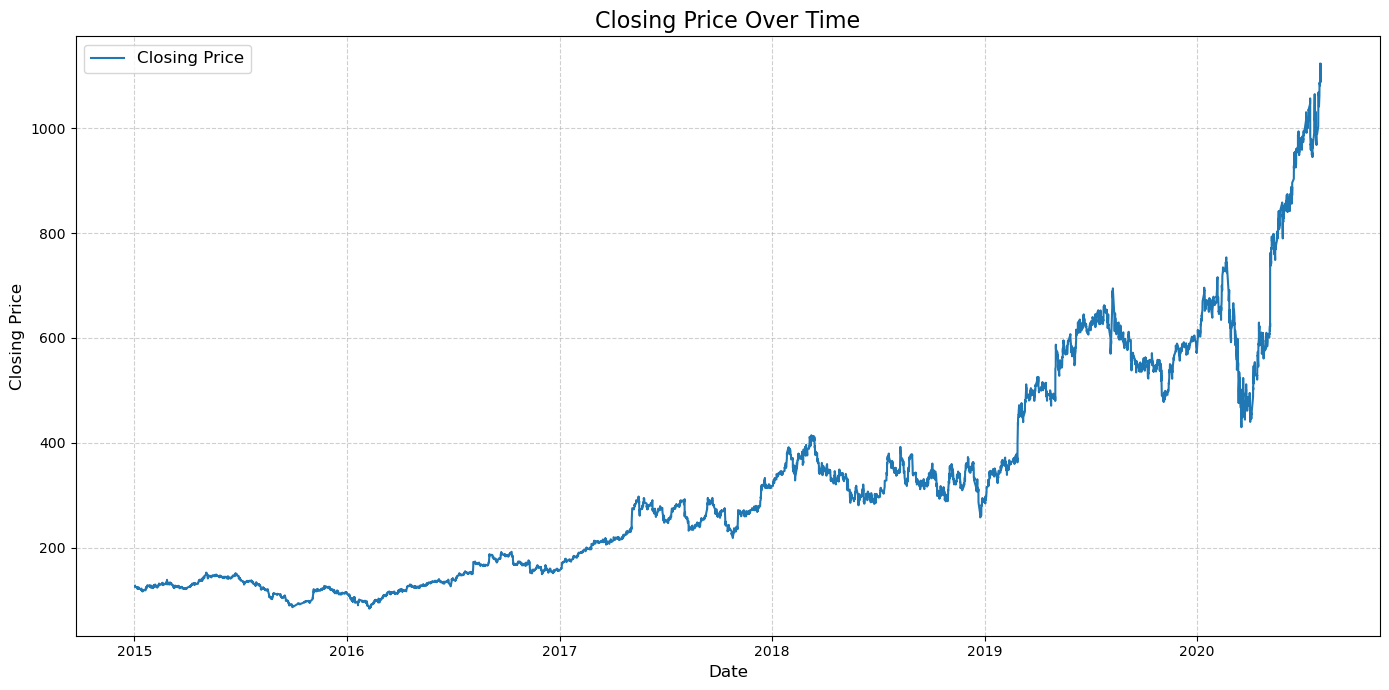

In [33]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(14, 7))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'], label='Closing Price', linewidth=1.5)
plt.title('Closing Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [46]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_combined = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
df_combined_first_last = pd.concat([df_combined.head(5), df_combined.tail(5)])
df_combined_first_last


close  Search Trends
2016-06-01 09:00:00   135.160            6.0
2016-06-01 10:00:00   136.630           12.0
2016-06-01 11:00:00   136.560           22.0
2016-06-01 12:00:00   136.420           33.0
2016-06-01 13:00:00   136.100           40.0
2020-07-31 11:00:00  1105.780           20.0
2020-07-31 12:00:00  1087.925           32.0
2020-07-31 13:00:00  1095.800           41.0
2020-07-31 14:00:00  1110.650           47.0
2020-07-31 15:00:00  1122.510           53.0

#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [50]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
df_first_half_2020 = df_combined.loc['2020-01':'2020-06']


# View the first and last five rows of first_half_2020 DataFrame
df_first_half_2020_first_last = pd.concat([df_first_half_2020.head(5), df_first_half_2020.tail(5)])

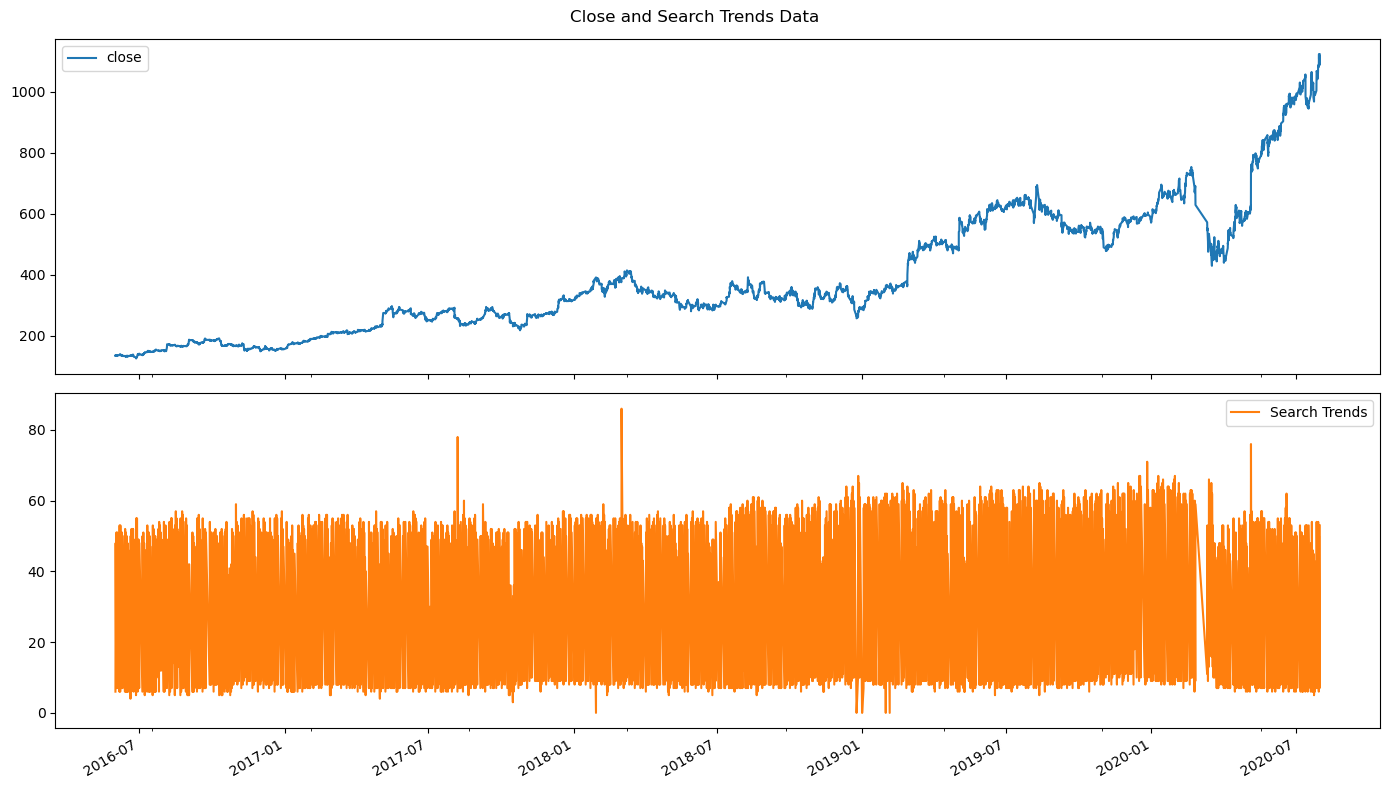

In [54]:
# Visualize the close and Search Trends data
if 'close' in df_combined.columns and 'Search Trends' in df_combined.columns:
    # Plot the data
    df_combined[['close', 'Search Trends']].plot(
        subplots=True,
        figsize=(14, 8),
        title='Close and Search Trends Data',
        legend=True
    )

# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
plt.tight_layout()
plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** correlation = df_combined['close'].corr(df_combined['Search Trends']) = 0.0002921851723440421 this low correlation suggests that the trends in search activity and stock price do not align.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [63]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
df_combined['Lagged Search Trends'] = df_combined['Search Trends'].shift(1)
df_combined['Lagged Search Trends']




2016-06-01 09:00:00     NaN
2016-06-01 10:00:00     6.0
2016-06-01 11:00:00    12.0
2016-06-01 12:00:00    22.0
2016-06-01 13:00:00    33.0
                       ... 
2020-07-31 11:00:00    11.0
2020-07-31 12:00:00    20.0
2020-07-31 13:00:00    32.0
2020-07-31 14:00:00    41.0
2020-07-31 15:00:00    47.0
Name: Lagged Search Trends, Length: 7067, dtype: float64

In [65]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
df_combined['Stock Returns'] = df_combined['close'].pct_change()

# Create a new column for stock volatility using a 4-period rolling window
df_combined['Stock Volatility'] = df_combined['Stock Returns'].rolling(window=4).std()

df_combined['Stock Returns'], df_combined['Stock Volatility']



(2016-06-01 09:00:00         NaN
 2016-06-01 10:00:00    0.010876
 2016-06-01 11:00:00   -0.000512
 2016-06-01 12:00:00   -0.001025
 2016-06-01 13:00:00   -0.002346
                          ...   
 2020-07-31 11:00:00    0.006380
 2020-07-31 12:00:00   -0.016147
 2020-07-31 13:00:00    0.007239
 2020-07-31 14:00:00    0.013552
 2020-07-31 15:00:00    0.010678
 Name: Stock Returns, Length: 7067, dtype: float64,
 2016-06-01 09:00:00         NaN
 2016-06-01 10:00:00         NaN
 2016-06-01 11:00:00         NaN
 2016-06-01 12:00:00         NaN
 2016-06-01 13:00:00    0.006134
                          ...   
 2020-07-31 11:00:00    0.012837
 2020-07-31 12:00:00    0.013549
 2020-07-31 13:00:00    0.013295
 2020-07-31 14:00:00    0.013001
 2020-07-31 15:00:00    0.013566
 Name: Stock Volatility, Length: 7067, dtype: float64)

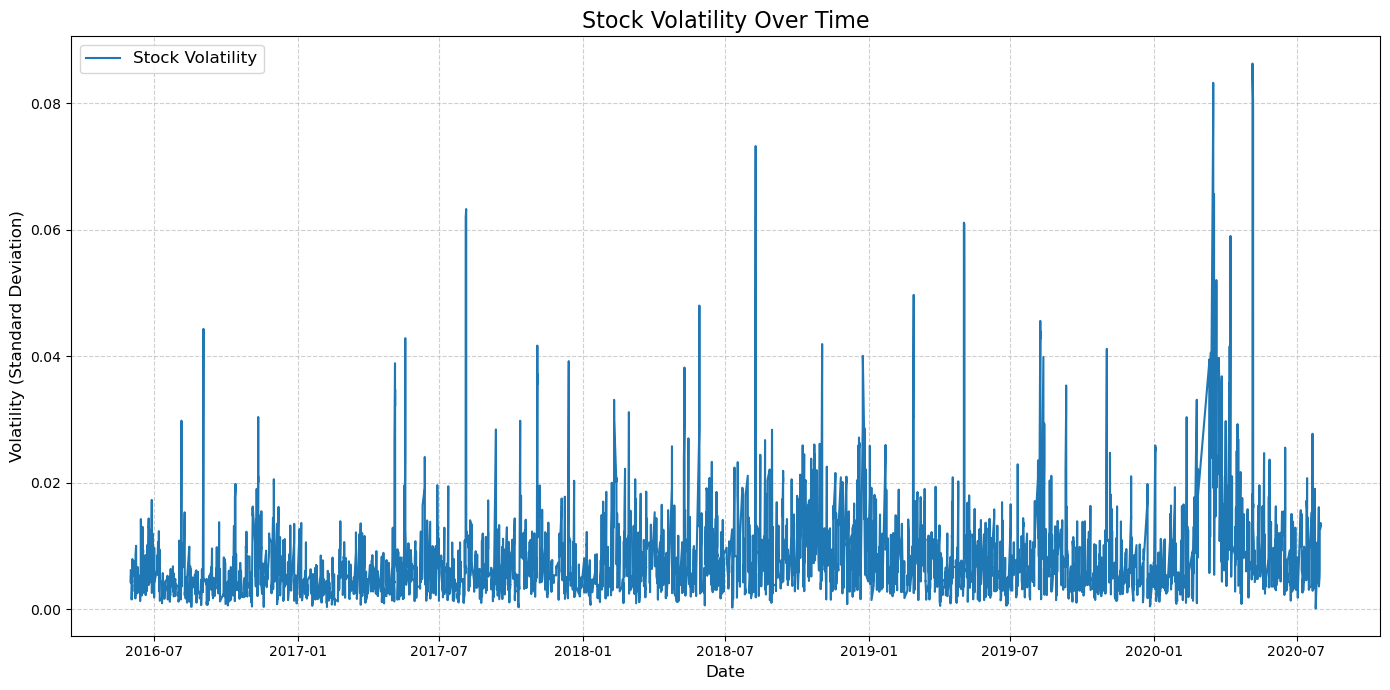

In [66]:
# Visualize the stock volatility
plt.figure(figsize=(14, 7))
plt.plot(df_combined.index, df_combined['Stock Volatility'], label='Stock Volatility', linewidth=1.5)
plt.title('Stock Volatility Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (Standard Deviation)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [67]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

df_combined['Hourly Stock Return'] = df_combined['close'].pct_change() * 100

In [71]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
df_first_last_rows = pd.concat([df_combined.head(5), df_combined.tail(5)])
df_first_last_rows



close  Search Trends  Lagged Search Trends  \
2016-06-01 09:00:00   135.160            6.0                   NaN   
2016-06-01 10:00:00   136.630           12.0                   6.0   
2016-06-01 11:00:00   136.560           22.0                  12.0   
2016-06-01 12:00:00   136.420           33.0                  22.0   
2016-06-01 13:00:00   136.100           40.0                  33.0   
2020-07-31 11:00:00  1105.780           20.0                  11.0   
2020-07-31 12:00:00  1087.925           32.0                  20.0   
2020-07-31 13:00:00  1095.800           41.0                  32.0   
2020-07-31 14:00:00  1110.650           47.0                  41.0   
2020-07-31 15:00:00  1122.510           53.0                  47.0   

                     Stock Returns  Stock Volatility  Hourly Stock Return  
2016-06-01 09:00:00            NaN               NaN                  NaN  
2016-06-01 10:00:00       0.010876               NaN             1.087600  
2016-06-01 11:00:00      -0.000512               NaN            -0.051233  
2016-06-01 12:00:00      -0.001025               NaN            -0.102519  
2016-06-01 13:00:00      -0.002346          0.006134            -0.234570  
2020-07-31 11:00:00       0.006380          0.012837             0.637986  
2020-07-31 12:00:00      -0.016147          0.013549            -1.614697  
2020-07-31 13:00:00       0.007239          0.013295             0.723855  
2020-07-31 14:00:00       0.013552          0.013001             1.355174  
2020-07-31 15:00:00       0.010678          0.013566             1.067843

#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [ ]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

Stock Volatility  Lagged Search Trends  \
Stock Volatility              1.000000             -0.148938   
Lagged Search Trends         -0.148938              1.000000   
Hourly Stock Return           0.061424              0.017929   

                      Hourly Stock Return  
Stock Volatility                 0.061424  
Lagged Search Trends             0.017929  
Hourly Stock Return              1.000000

##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** Based on the initial analysis, it appears that there is no strong linear or predictable relationship between the lagged search traffic and either stock volatility or stock returns. Here's a breakdown:

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [113]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends_reset = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet

df_mercado_trends_for_prophet = df_mercado_trends_reset.rename(columns={'Date': 'ds', 'Search Trends': 'y'})
# Drop an NaN values from the prophet_df DataFrame
df_mercado_trends_for_prophet_cleaned = df_mercado_trends_for_prophet.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
df_first_last = pd.concat([df_mercado_trends_for_prophet_cleaned.head(), df_mercado_trends_for_prophet_cleaned.tail()])
df_first_last

ds   y
0     2016-06-01 00:00:00  97
1     2016-06-01 01:00:00  92
2     2016-06-01 02:00:00  76
3     2016-06-01 03:00:00  60
4     2016-06-01 04:00:00  38
37101 2020-09-07 20:00:00  71
37102 2020-09-07 21:00:00  83
37103 2020-09-07 22:00:00  96
37104 2020-09-07 23:00:00  97
37105 2020-09-08 00:00:00  96

In [115]:
# Call the Prophet function, store as an object
prophet_model = Prophet()
prophet_model

In [119]:
# Fit the time-prophet_model.fit(df_mercado_trends_for_prophet_cleaned)
prophet_model.fit(df_mercado_trends_for_prophet_cleaned)

future_df = prophet_model.make_future_dataframe(periods=2000, freq='h')
future_df.head(), future_df.tail()

14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:25 - cmdstanpy - INFO - Chain [1] done processing


(                   ds
 0 2016-06-01 00:00:00
 1 2016-06-01 01:00:00
 2 2016-06-01 02:00:00
 3 2016-06-01 03:00:00
 4 2016-06-01 04:00:00,
                        ds
 39101 2020-11-30 04:00:00
 39102 2020-11-30 05:00:00
 39103 2020-11-30 06:00:00
 39104 2020-11-30 07:00:00
 39105 2020-11-30 08:00:00)

In [121]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
prophet_model = Prophet()
prophet_model.fit(df_mercado_trends_for_prophet_cleaned)
future_df = prophet_model.make_future_dataframe(periods=2000, freq='h')

future_df.head(), future_df.tail()

# View the last five rows of the future_mercado_trends DataFrame
future_df.head(), future_df.tail()


15:00:47 - cmdstanpy - INFO - Chain [1] start processing
15:00:56 - cmdstanpy - INFO - Chain [1] done processing


(                   ds
 0 2016-06-01 00:00:00
 1 2016-06-01 01:00:00
 2 2016-06-01 02:00:00
 3 2016-06-01 03:00:00
 4 2016-06-01 04:00:00,
                        ds
 39101 2020-11-30 04:00:00
 39102 2020-11-30 05:00:00
 39103 2020-11-30 06:00:00
 39104 2020-11-30 07:00:00
 39105 2020-11-30 08:00:00)

In [127]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
prophet_model = Prophet()
prophet_model.fit(df_mercado_trends_for_prophet_cleaned)
# Step 2: Create a future DataFrame
future_mercado_trends = prophet_model.make_future_dataframe(periods=2000, freq='H')
# Step 3: Generate predictions
forecast = prophet_model.predict(future_mercado_trends)
# Step 4: Display the predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

# Display the first five rows of the forecast_mercado_trends DataFrame

15:06:34 - cmdstanpy - INFO - Chain [1] start processing
15:06:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\patri\anaconda3\envs\dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


ds       yhat  yhat_lower  yhat_upper
0 2016-06-01 00:00:00  89.659992   81.530015   97.634775
1 2016-06-01 01:00:00  86.106654   77.689892   94.286428
2 2016-06-01 02:00:00  75.784037   67.746190   83.771947
3 2016-06-01 03:00:00  60.517701   51.846964   69.004479
4 2016-06-01 04:00:00  43.403713   35.068643   52.301904

#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

15:15:48 - cmdstanpy - INFO - Chain [1] start processing
15:15:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\patri\anaconda3\envs\dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
C:\Users\patri\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\patri\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.histo

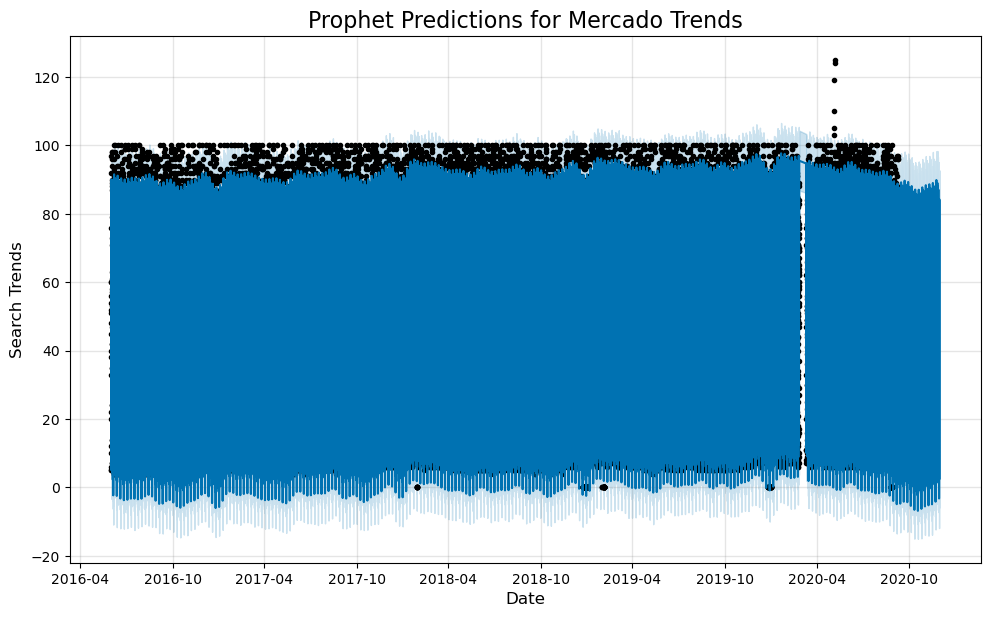

In [130]:
# Plot the Prophet predictions for the Mercado trends data
prophet_model = Prophet()
# Step 1: Fit the Prophet model (if not already done)
prophet_model.fit(df_mercado_trends_for_prophet_cleaned)

# Step 2: Create a future DataFrame
future_mercado_trends = prophet_model.make_future_dataframe(periods=2000, freq='H')

# Step 3: Generate predictions
forecast = prophet_model.predict(future_mercado_trends)

# Step 4: Plot the forecast
prophet_model.plot(forecast)
plt.title('Prophet Predictions for Mercado Trends', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.show()


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**The intervals  - seem to statilize (yhat_upper and yhat_lower)  but the downward trajectory of(yhat_upper and yhat_lower)may indicate uncertainty in the forecast, making it harder to draw conclusions.



#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [133]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column

forecast_mercado_trends = prophet_model.predict(future_mercado_trends)

forecast_mercado_trends.set_index('ds', inplace=True)

# Display the first few rows to confirm the change
forecast_mercado_trends.head()


# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
# View only the yhat, yhat_lower, and yhat_upper columns
forecast_subset = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]

# Display the subset
forecast_subset.head()



yhat  yhat_lower  yhat_upper
ds                                                    
2016-06-01 00:00:00  89.659992   80.856927   98.172191
2016-06-01 01:00:00  86.106654   76.958955   94.736112
2016-06-01 02:00:00  75.784037   67.012804   84.206204
2016-06-01 03:00:00  60.517701   52.455188   69.581579
2016-06-01 04:00:00  43.403713   35.041495   51.415023

Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

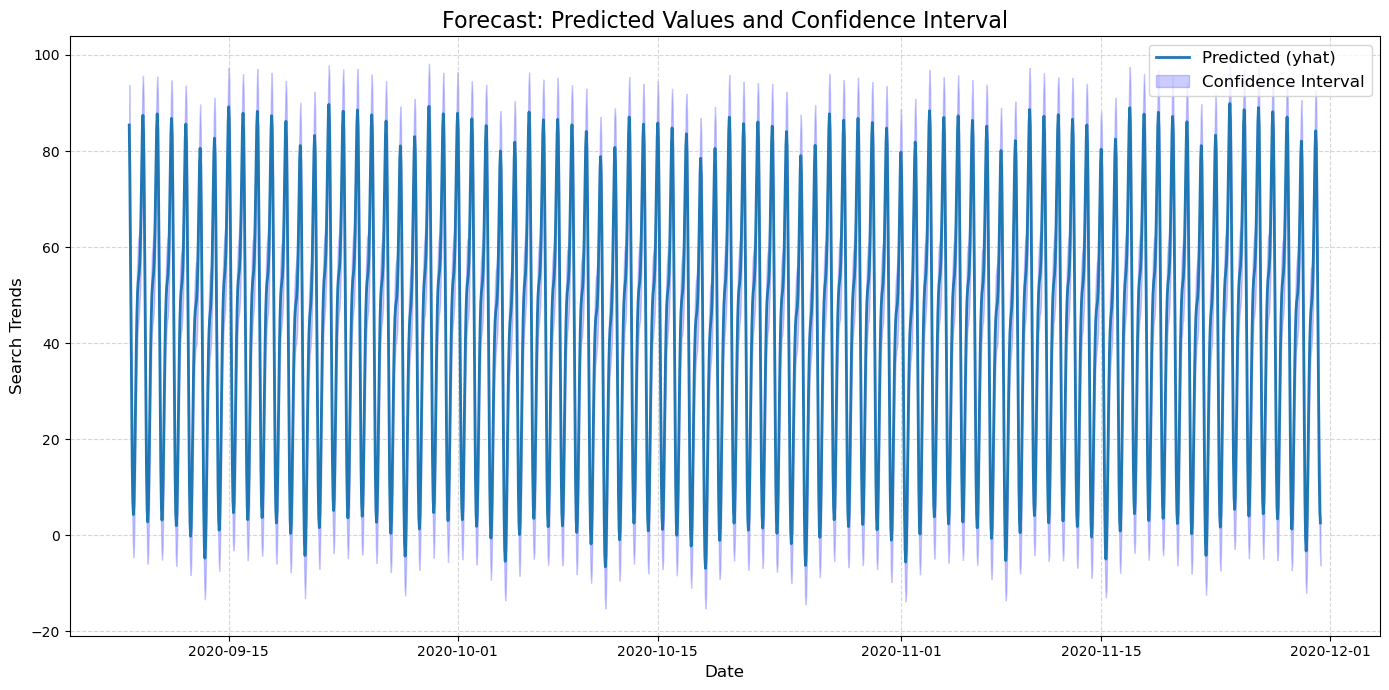

In [134]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
import matplotlib.pyplot as plt

# Filter the last 2000 hours from the forecast DataFrame
forecast_last_2000 = forecast_mercado_trends.tail(2000)

# Plot the yhat, yhat_lower, and yhat_upper
plt.figure(figsize=(14, 7))
plt.plot(forecast_last_2000.index, forecast_last_2000['yhat'], label='Predicted (yhat)', linewidth=2)
plt.fill_between(
    forecast_last_2000.index,
    forecast_last_2000['yhat_lower'],
    forecast_last_2000['yhat_upper'],
    color='blue',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title('Forecast: Predicted Values and Confidence Interval', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



C:\Users\patri\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\patri\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\patri\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

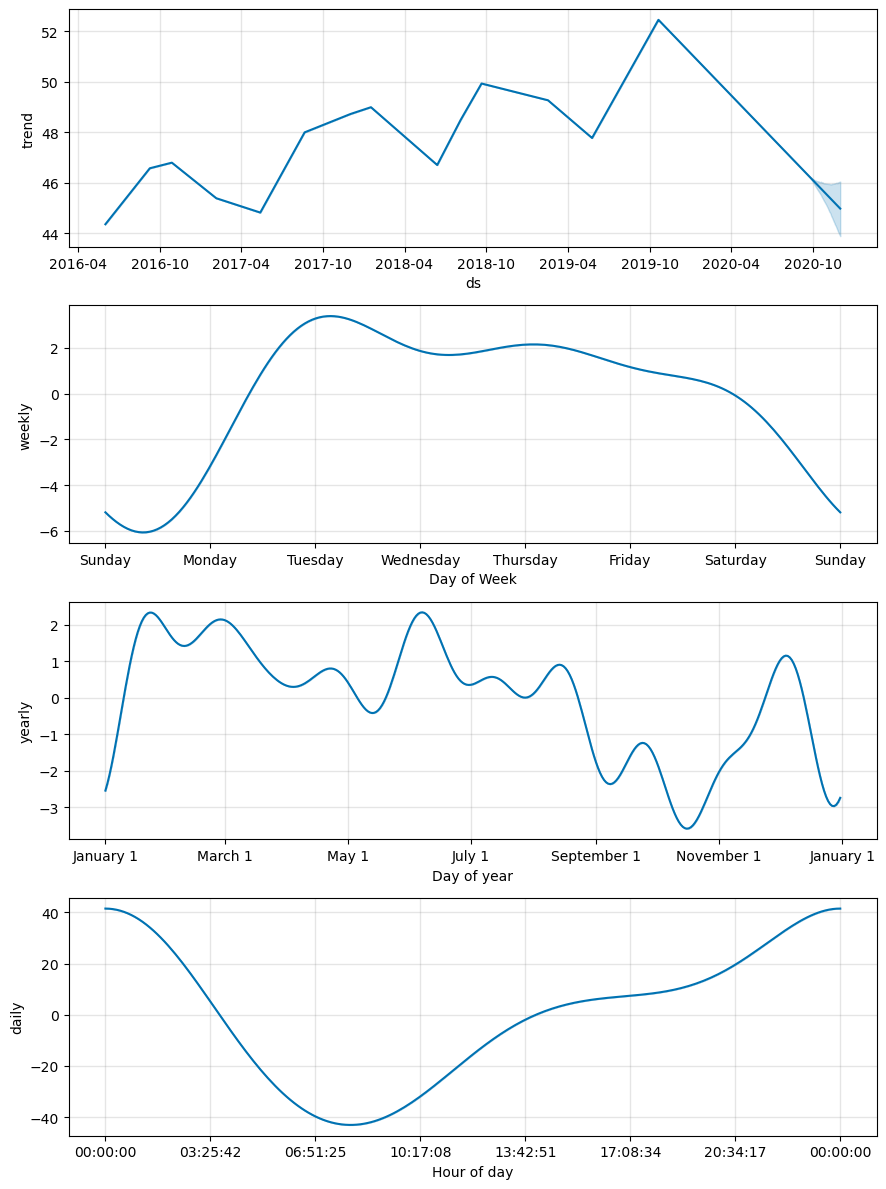

In [136]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
# Visualize the components of the forecast
fig = prophet_model.plot_components(forecast_mercado_trends)

# Show the plot
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** The hour with most popularity seems to be midnight

**Question:** Which day of week gets the most search traffic?
   
**Answer:** The day of the week -  Tuesday seems to have held the popularity.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Late November - appears close to Thanksgiving.
